In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import scipy.stats
import matplotlib.pyplot as plt


In [4]:
base_keys = list({
                'gACH':(0,0),
                'rDA':(0,0),
                'gDA':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideInIndexnr':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
                }.keys())
shortened_keys = [dfh.shorten_col_name(_) for _ in base_keys]

all_alignment_cols = [
                        'SIAA', 'SIAa', 'SIaA', 'SIaa',
                        'SIAB', 'SIAb', 'SIaB', 'SIab',
                        'SIr', 'SInr', 
                     ]
# base_keys

In [5]:
def get_delta_list(event_srs, event_col, keep_srs):
    
    keep_eg_lst = []
    delta_keep_eg_lst = []

    rdc = []
    entry_num = np.arange(len(event_srs))
    event = np.where(event_srs.values == 1)
    assert len(event) == 1
    event = event[0]
    
    for iev, ev in enumerate(event):
        delta = entry_num - ev
        keep_eg = (delta >= -40)&(delta <= 100)&keep_srs
        delta_keep_eg = delta[keep_eg]
        keep_eg_lst.append(keep_eg)
        delta_keep_eg_lst.append(delta_keep_eg)

    return keep_eg_lst, delta_keep_eg_lst

# full_df = h5_lst[0]


In [6]:
h5_lst = defaultdict(list)
run_id_dct = defaultdict(list)

# base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')
base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

fig_folder_lst = [('Figure_1_2', 'f1*-ft'),
                  ('Figure_3',   'f3*-ft'),
                  ('Figure_4_g1',   'f4*-ft'),
                  ('Figure_4_g2',   'f4*-ft'),
                  ('Figure_5_g1',   'f5*-ft'),
                  ('Figure_5_g2',   'f5*-ft'),
                  ('Figure_5_g5',   'f5*-ft'),
                 ]

for fig_folder in fig_folder_lst:
    print('fig_folder', fig_folder)
    
    load_folder = base_location / Path(fig_folder[0])
    # load_folder = base_location / Path(r'tmp')
    h5_recons_locations = str((load_folder / Path('all') / Path(fig_folder[1]) / Path(r'reconstructs\best_resids_*.h5')).resolve())
    
    print(h5_recons_locations)
    
#     load_folder = base_location / Path(r'Figure_1_2')
#     # load_folder = base_location / Path(r'tmp')
#     h5_recons_locations = str((load_folder / Path(r'all\f1*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # h5_recons_locations = str((load_folder / Path(r'all/f1*-ft/reconstructs/best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_3')
#     # h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_4_g1')
#     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_4_g2')
#     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g1')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g2')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g5')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

    out_folder = base_location / Path(r'final_outputs')

    out_loc = str((out_folder).resolve())
    h5_recons_locations = glob.glob(h5_recons_locations)





    for h5_coef_fn in h5_recons_locations:
        h5f = pd.HDFStore(h5_coef_fn)
        h5fk = h5f.keys()
        for key in h5fk:

            resp = key.split('_')[0].replace('/', '')
            model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]

            if 'run_num' in key and 'run_num__0' not in key: #and 'run_num__1' not in key:
                continue
            if 'base_simple' not in key and 'base_words' not in key and 'basis' not in key:
                continue
            print(key, model_version)

            y_col = key.split('_')[0].replace(r'/', r'')
            h5_df = pd.read_hdf(h5f, key)

            h5_df.columns = [dfh.shorten_col_name(_) for _ in h5_df.columns]

            if 'dfrel_basis' != key.replace('/', ''):
                h5_df.columns = [_.split('_')[0] for _ in h5_df.columns]
                h5_df['true'] = h5_lst['dfrel'][0][y_col]
                h5_df['resid2'] = (h5_df['true'] - h5_df['pred'])**2

                h5_df['file_num'] = h5_lst['dfrel'][0]['file_num']

                h5_df['dupe'] = h5_lst['dfrel'][0]['dupe']
                h5_df['wi_trial_keep'] = h5_lst['dfrel'][0]['wi_trial_keep']

                h5_lst[y_col].append(h5_df)
                run_id_dct[y_col].append(model_version)
            else:
                h5_lst[y_col].append(h5_df)
                run_id_dct[y_col].append('basis')


    for i in range(2):
        for y_col in ['gACH', 'rDA', 'gDA']:
#             fig,axes = plt.subplots(5,2,figsize=(10,30))

            combo_rdc = {}
            for iac, alignment_col in enumerate(all_alignment_cols):
#                 ic, ir = iac%2, iac//2
#                 ax = axes[ir, ic]

                dupe = h5_lst['dfrel'][0]['dupe']
                dfrel_basis = h5_lst['dfrel'][0].loc[~dupe]
                dfrel_basis_run = h5_lst[y_col][i].loc[~dupe]

                model_version = run_id_dct[y_col][i]

                print('Pulling delta list')
                keep_rows, assoc_deltas = get_delta_list(dfrel_basis[alignment_col], alignment_col, ((dfrel_basis_run['holdout']==1)).astype(bool))
                rdc_lst = defaultdict(list)
                for entry_num in trange(len(keep_rows)):
                    keep_row_single = keep_rows[entry_num]
                    deltas = assoc_deltas[entry_num]
                    rdc_df = dfrel_basis_run.loc[keep_row_single].set_index(deltas)

                    if rdc_df['file_num'].nunique() > 1:
                        continue

                    reconstruction_data_list = []

                    for bootstrap_col in ['true', 'pred']:
                        rdc_lst[bootstrap_col].append(rdc_df[[bootstrap_col]])

                print('keys', rdc_lst.keys())

                seed = np.random.randint(1000000000)
                for bootstrap_col in (rdc_lst):
                    tmp_rdc = pd.concat(rdc_lst[bootstrap_col], axis=1).sort_index()

                    reconstruction_data_list = []
                    for delta in (tmp_rdc.index):
                        row = tmp_rdc.loc[delta].dropna().values
                        bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
    #                     bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=1000,
                                                   batch=None, vectorized=True, paired=False,
                                                   axis=0, confidence_level=0.95, method='BCa',
                                                   random_state=seed)

                        mn_val = row.mean()
                        rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

                        reconstruction_data_list.append(rtup)

                    tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
                    combo_rdc[f'{alignment_col}_{bootstrap_col}'] = tmp_combo_rdc.drop('basis_column',axis=1)

            combo_rdc = pd.concat(combo_rdc, axis=1)
            combo_rdc.columns = ['_'.join(_).replace('_true_', '_T_').replace('_pred_', '_P_') for _ in combo_rdc.columns]
            combo_rdc.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-reconstruct-{y_col}={model_version}.csv').resolve()))


fig_folder ('Figure_1_2', 'f1*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_1_2\all\f1*-ft\reconstructs\best_resids_*.h5
/dfrel_basis 
/gACH_0_0_base_simple_run_num__0 base_simple
/gACH_0_8_base_words_run_num__0 base_words
/dfrel_basis 
/rDA_1_0_base_simple_run_num__0 base_simple
/rDA_1_8_base_words_run_num__0 base_words
/dfrel_basis 
/gDA_2_0_base_simple_run_num__0 base_simple
/gDA_2_8_base_words_run_num__0 base_words
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_3', 'f3*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_3\all\f3*-ft\reconstructs\best_resids_*.h5
/dfrel_basis 
/gACH_0_2_base_simple_gDA_to_gACH_run_num__0 base_simple_gDA_to_gACH
/gACH_0_3_base_words_gDA_to_gACH_run_num__0 base_words_gDA_to_gACH
/gACH_0_4_base_simple_rDA_to_gACH_run_num__0 base_simple_rDA_to_gACH
/gACH_0_5_base_words_gDA_to_gACH_run_num__0 base_words_gDA_to_gACH
/gACH_0_6_base_simple_run_num__0 base_simple
/gACH_0_7_base_words_run_num__0 base_words
/dfrel_basis 
/gDA_1_1_base_simple_gACH_to_gDA_run_num__0 base_simple_gACH_to_gDA
/gDA_1_2_base_words_gACH_to_gDA_run_num__0 base_words_gACH_to_gDA
/gDA_1_3_base_simple_run_num__0 base_simple
/gDA_1_4_base_words_run_num__0 base_words
/dfrel_basis 
/rDA_2_1_base_simple_gACH_to_rDA_run_num__0 base_simple_gACH_to_rDA
/rDA_2_2_base_words_gACH_to_rDA_run_num__0 base_words_gACH_to_rDA
/rDA_2_3_base_simple_run_num__0 base_simple
/rDA_2_4_base_words_run

  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_4_g1', 'f4*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_4_g1\all\f4*-ft\reconstructs\best_resids_*.h5
/dfrel_basis 
/gDA_0_0_base_simple_run_num__0 base_simple
/gDA_0_1_base_words_run_num__0 base_words
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_4_g2', 'f4*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_4_g2\all\f4*-ft\reconstructs\best_resids_*.h5
/dfrel_basis 
/gDA_0_0_base_simple_run_num__0 base_simple
/gDA_0_1_base_words_run_num__0 base_words
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_5_g1', 'f5*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_5_g1\all\f5*-ft\reconstructs\best_resids_*.h5
/dfrel_basis 
/gACH_0_2_base_simple_gDA_to_gACH_run_num__0 base_simple_gDA_to_gACH
/gACH_0_3_base_words_gDA_to_gACH_run_num__0 base_words_gDA_to_gACH
/gACH_0_4_base_simple_rDA_to_gACH_run_num__0 base_simple_rDA_to_gACH
/gACH_0_5_base_words_gDA_to_gACH_run_num__0 base_words_gDA_to_gACH
/gACH_0_6_base_simple_run_num__0 base_simple
/gACH_0_7_base_words_run_num__0 base_words
/dfrel_basis 
/gDA_1_1_base_simple_gACH_to_gDA_run_num__0 base_simple_gACH_to_gDA
/gDA_1_2_base_words_gACH_to_gDA_run_num__0 base_words_gACH_to_gDA
/gDA_1_3_base_simple_run_num__0 base_simple
/gDA_1_4_base_words_run_num__0 base_words
/dfrel_basis 
/rDA_2_1_base_simple_gACH_to_rDA_run_num__0 base_simple_gACH_to_rDA
/rDA_2_2_base_words_gACH_to_rDA_run_num__0 base_words_gACH_to_rDA
/rDA_2_3_base_simple_run_num__0 base_simple
/rDA_2_4_base_wor

  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_5_g2', 'f5*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_5_g2\all\f5*-ft\reconstructs\best_resids_*.h5
/dfrel_basis 
/gACH_0_2_base_simple_gDA_to_gACH_run_num__0 base_simple_gDA_to_gACH
/gACH_0_3_base_words_gDA_to_gACH_run_num__0 base_words_gDA_to_gACH
/gACH_0_4_base_simple_rDA_to_gACH_run_num__0 base_simple_rDA_to_gACH
/gACH_0_5_base_words_gDA_to_gACH_run_num__0 base_words_gDA_to_gACH
/gACH_0_6_base_simple_run_num__0 base_simple
/gACH_0_7_base_words_run_num__0 base_words
/dfrel_basis 
/gDA_1_1_base_simple_gACH_to_gDA_run_num__0 base_simple_gACH_to_gDA
/gDA_1_2_base_words_gACH_to_gDA_run_num__0 base_words_gACH_to_gDA
/gDA_1_3_base_simple_run_num__0 base_simple
/gDA_1_4_base_words_run_num__0 base_words
/dfrel_basis 
/rDA_2_1_base_simple_gACH_to_rDA_run_num__0 base_simple_gACH_to_rDA
/rDA_2_2_base_words_gACH_to_rDA_run_num__0 base_words_gACH_to_rDA
/rDA_2_3_base_simple_run_num__0 base_simple
/rDA_2_4_base_wor

  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
fig_folder ('Figure_5_g5', 'f5*-ft')
C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs\Figure_5_g5\all\f5*-ft\reconstructs\best_resids_*.h5
/dfrel_basis 
/gACH_0_2_base_simple_gDA_to_gACH_run_num__0 base_simple_gDA_to_gACH
/gACH_0_3_base_words_gDA_to_gACH_run_num__0 base_words_gDA_to_gACH
/gACH_0_4_base_simple_rDA_to_gACH_run_num__0 base_simple_rDA_to_gACH
/gACH_0_5_base_words_gDA_to_gACH_run_num__0 base_words_gDA_to_gACH
/gACH_0_6_base_simple_run_num__0 base_simple
/gACH_0_7_base_words_run_num__0 base_words
/dfrel_basis 
/gDA_1_1_base_simple_gACH_to_gDA_run_num__0 base_simple_gACH_to_gDA
/gDA_1_2_base_words_gACH_to_gDA_run_num__0 base_words_gACH_to_gDA
/gDA_1_3_base_simple_run_num__0 base_simple
/gDA_1_4_base_words_run_num__0 base_words
/dfrel_basis 
/rDA_2_1_base_simple_gACH_to_rDA_run_num__0 base_simple_gACH_to_rDA
/rDA_2_2_base_words_gACH_to_rDA_run_num__0 base_words_gACH_to_rDA
/rDA_2_3_base_simple_run_num__0 base_simple
/rDA_2_4_base_wor

  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/9602 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/2076 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1296 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1927 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/175 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/862 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/1643 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/707 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/12716 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Pulling delta list


  0%|          | 0/5572 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])


<AxesSubplot:xlabel='delta'>

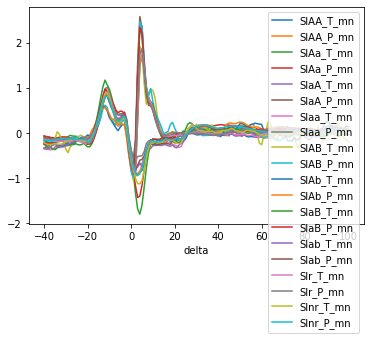

In [7]:
combo_rdc[[_ for _ in combo_rdc.columns if '_mn' in _]].plot()

In [8]:
y_col, model_version

('gDA', 'base_words')

In [9]:
# run_id_dct[y_col]